## Разряженный автоэнкодер
Драпак Степан 317гр.
### Цель задания:
Ознакомится с нейросетевым подходом к решению задач классификации и факторного анализа. Протестировать разряженный автоэнкодер в задачах распознавания изображения. Кроме того требуется понять почему происходит улучшение/ухудшение результатов работы традиционных методов на данных сгенерированных энкодером, а также проанализировать структуру энкодера и то как он выделяет зависимости в изображениях. 

В задании используются обертки на функциями из спецификации, которые можно найти в соответствующих модулях, однако сама спецификация полностью соблюдена.

Для начала разберемся с регуляризатором, выведем соответствующие формулы. Рассмотрим слой к которому применяем разряживающий регуляризатор. (Слой разумеется внутренний) 
Понятно, что в общем виде $\frac{\partial L}{\partial W_{ij}^{(l)}} = a_{j}^{(l)}\delta_{i}^{(l+1)}$.
Главный вопрос - как вычислять $\delta$? Первое слагаемое сохранится как в исходном энкодере, посмотрим какой вклад даст KL дивергенция
$\delta = \frac{\partial (KL)}{\partial z} = (\sum_{j} \rho \log \frac{\rho}{\rho_{j}} +
(1 - \rho) \log \frac{1 - \rho}{1 - \rho_{j}})_{z} = (\sum_{j} \rho (\log \rho - \log \rho_{j}) + 
(1 - \rho)( \log (1 - \rho) - \log (1 - \rho_{j})))_{z}$

Здесь от z зависит только $\rho_{j}$, поэтому в итоге:
$\delta = \frac{\partial (KL)}{\partial z} = (\sum_{j} \frac{-\rho}{\rho_{j}} + \frac{1 - \rho}{1 - \rho_{j}})\frac{\partial \sigma(z)}{\partial z} $

(Здесь $z = z_{i}^{(l)})$





In [ ]:
from sample_patches import *
from gradient import *
from autoencoder import *
from display_layer import *
import numpy as np

In [2]:
%matplotlib inline

Для начала проверим функцию разностной апроксимации градиента. Для этого в функции check_gradient зададим функцию
$$f(x_1, x_2) = x_1^2 + x_2^3 $$
и вычислим ее градиент в точке (5, 10), он очевидно равен (10, -300). Именно это и проверяет функцию check_gradient.

In [3]:
check_gradient()

True

Теперь проверим с помощью разностной апроксимации нашу функцию вычисления градиента

In [12]:
f = open('patches.pk', 'r')
patches = pickle.load(f)

In [14]:
visible_size = 192
#random_data = np.random.rand(1000, visible_size)
random_data = patches[:1000]/255.0
hidden_size = np.array([5, 3, 5])
lambda_ = 0.0001
beta = 3.0
sparsity_param = 0.01
grad_test_theta = initialize(hidden_size=hidden_size, visible_size=visible_size)
loss = lambda x: autoencoder_loss(x, visible_size=visible_size, hidden_size=hidden_size, lambda_=lambda_,
                                  sparsity_param=sparsity_param, beta=beta, data=random_data)[0]
my_loss, my_grad = autoencoder_loss(grad_test_theta, visible_size=visible_size, hidden_size=hidden_size, lambda_=lambda_,
                                  sparsity_param=sparsity_param, beta=beta, data=random_data)
dif_aprox = compute_gradient(loss, grad_test_theta, 1e-5)


In [15]:
print np.sqrt(np.sum((my_grad + dif_aprox)**2)/float(my_grad.shape[0]))

8.03540651658e-11


Получаем, что для выборки из 1000 патчей и сети с 3 скрытими слоями RMSE порядка 1e-11, что позволяет надеятся на то, что вычисление градиента выполняется верно.

Теперь обучим наш автокодировщик и визуализируем скрытые слои. Для этого сгенерируем патчи из неразмеченой выборки с помощью обертки специфицированной функции.

In [33]:
unlabel_list = ['X1.pk', 'X2.pk', 'X3.pk', 'X4.pk', 'X5.pk']
patches = no_system_overload_sample_patches(unlabel_list, num_patches=10000, patch_size=8, normalize=True)

In [9]:
import pickle

In [ ]:
f = open('patches.pk', 'w')
pickle.dump(patches, f)
f.close()

In [28]:
f = open('patches.pk', 'r')
patches = pickle.load(f)
f.close()

Посмотрим как выглядят патчи

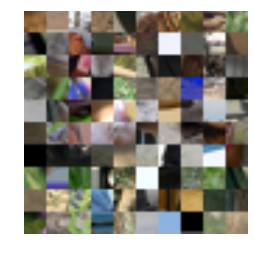

In [4]:
display_layer(patches[:100])

Натренируем нашу первую прилиную сеть и посмотрим как будут выглядить веса на первом слое

In [76]:
theta = autoencoder_fit(visible_size=192, hidden_size=np.array([75]), sparsity_param=0.01, 
                        lambda_=0.0001, beta=3, data=patches[:7500]/255.0, n_iter=4000)


In [20]:
def normalize(X):
    X = X.astype(float)
    return (X - np.min(X))/(np.max(X) - np.min(X))

In [79]:
first_layer_w = (theta[:192 * 75].reshape((75, 192)))
first_layer_w = normalize(first_layer_w)

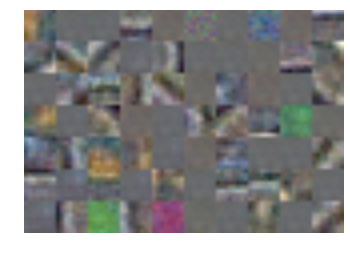

In [80]:
display_layer(first_layer_w * 255)

Ну, тут однозначно есть что-то общее с примером, хотя и выглядит не так красиво. Возможно дело в недостаточном объеме обучающей выборки или в недостаточно числе итераций. Тем не менее видны монотонные участки и границы между ними. Теперь немного изменим каждый из параметров и посмотрим что будет

In [18]:
def fit_and_drow(filename, sparsity_param=0.01, lambda_=0.0001, beta=3):
    theta = autoencoder_fit(visible_size=192, hidden_size=np.array([75]), sparsity_param=sparsity_param, 
                        lambda_= lambda_, beta=beta, data=patches[:7500]/255.0, n_iter=4000)
    first_layer_w = (theta[:192 * 75].reshape((75, 192)))
    first_layer_w = normalize(first_layer_w)
    display_layer(first_layer_w * 255)


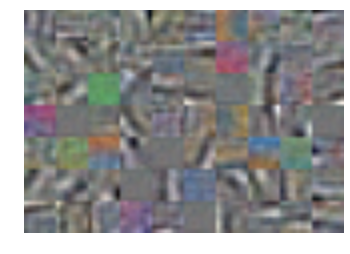

sparsitiy_param = 0.05


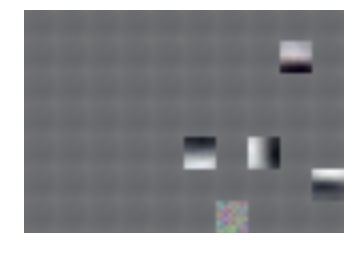

lambda = 0.001


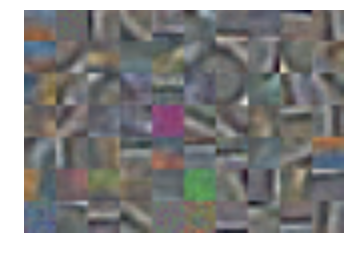

beta=1


In [23]:
fit_and_drow('sp_005', sparsity_param=0.05)
print 'sparsitiy_param = 0.05'
fit_and_drow('lambda_0001', lambda_=0.001)
print 'lambda = 0.001'
fit_and_drow('beta_1', beta=1)
print 'beta=1'

При увеличении параметра разряженности получили более размытые изображения, но при это число изображений, не являющихся полностью серыми возросло. Это логично, число близких к 0 весов уменьшилось, так как распределение на внутреннем слое стало менее разряженным.

Когда мы поменяли коэффициент при l2 регуляризации все переходы совсем пропали, видимо все веса стали равномерно малы.

При уменьшении beta мы сного уменьшили требования к разряженности и поэтому наблюдаем схожий эффект с изменением alpha

Перейдем к тестам связанным с классификацией на полченных сетью парамраметрах

In [83]:
f = open('theta.pk', 'w')
pickle.dump(theta, f)
f.close()

In [3]:
f = open('theta.pk', 'r')
theta = pickle.load(f)
f.close()

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
train_X, train_y = download_data(['train.pk'])
#test_X, test_y = download_data(['test.pk'])

In [5]:
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier(n_estimators=100)

Для начала обучим случайный лес и логистическую регрессию на исходных пикселях изображения

In [46]:
lr_clf.fit(train_X, train_y.ravel())
rf_clf.fit(train_X, train_y.ravel())

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
del(train_X)
del(train_y)

In [49]:
test_X, test_y = download_data(['test.pk'])
pred_lr = lr_clf.predict(test_X)
pred_rf = rf_clf.predict(test_X)

In [10]:
def accuracy(y1, y2):
    y1 = y1.ravel()
    y2 = y2.ravel()
    return np.sum(y1 == y2)/float(y1.shape[0])

In [51]:
print accuracy(pred_lr, test_y)
print accuracy(pred_rf, test_y)

0.292
0.414375


Получилось, что RF значительно опередил логистическую регрессию

In [52]:
del(test_X)
del(test_y)
del(rf_clf)
del(lr_clf)

Теперь посмотрим что выдает сесть, если через нее полностью прогнать картинку(убедимся в том, что в выходных значениях есть смысл)

In [25]:
from experiments import *

In [57]:
del(train_X)

In [86]:
filtered_im = autoencoder_transform(theta=theta, visible_size=192, hidden_size=np.array([75]),
                                    layer_number=1, data=patches[:100]/255.0)

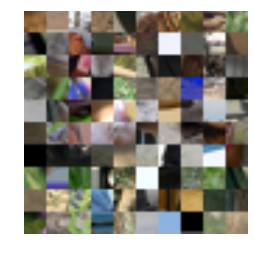

In [89]:
display_layer(patches[:100], filename='src_patches.png')

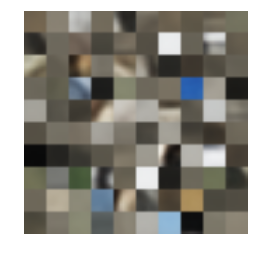

In [90]:
display_layer(filtered_im.reshape(192, 100).T * 255, filename='filtred_patches.png')

По крайней мере яркость и кое-где цвет сохраняется.

Теперь, для удобства, сгенерируем новые признаки, полученные на основе нашей сети и посмотрим как изменится качество на них

In [12]:
for st in [6, 8, 12, 16]:
    features_im = get_subimage_feature(images=train_X/255.0, step=st, patch_size=8, theta=theta, 
                                       visible_size=192, hidden_size=np.array([75]), layer_number=0)
    #f = open('train' + str(st) + '.pk', 'w')
    #pickle.dump(features_im, f)
    np.save(file='train' + str(st), arr=features_im)

In [13]:
del(train_X)

In [14]:
test_X, test_y = download_data(['test.pk'])

In [15]:
for st in [6, 8, 12, 16]:
    features_im = get_subimage_feature(images=test_X/255.0, step=st, patch_size=8, theta=theta, 
                                       visible_size=192, hidden_size=np.array([75]), layer_number=0)
    np.save(file='test' + str(st), arr=features_im)

In [9]:
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier(n_estimators=100)
_, train_y = download_data(['train.pk'])
_, test_y = download_data(['test.pk'])

In [12]:
for st in [6, 8, 12]:
    train = np.load('train' + str(st) + '.npy')
    lr_clf.fit(train, train_y.ravel())
    rf_clf.fit(train, train_y.ravel())
    del(train)
    test = np.load('test' + str(st) + '.npy')
    preds_lr = lr_clf.predict(test)
    preds_rf = rf_clf.predict(test)
    del(test)
    print 'LOGISTIC REGRESSION WITH STEP = ' + str(st) + ':'
    print accuracy(preds_lr, test_y)
    print 'RANDOM FOREST WITH STEP = ' + str(st) + ':'
    print accuracy(preds_rf, test_y)
    

LOGISTIC REGRESSION WITH STEP = 6:
0.451
RANDOM FOREST WITH STEP = 6:
0.417875
LOGISTIC REGRESSION WITH STEP = 8:
0.44925
RANDOM FOREST WITH STEP = 8:
0.424625
LOGISTIC REGRESSION WITH STEP = 12:
0.416125
RANDOM FOREST WITH STEP = 12:
0.40375


Тут сразу бросается в галаза значительно улучшение качества логистической регрессии. Видимо сесть смогла создать значительно лучше линейно разделимую выборку. При этом в RF лишь немного улучшил результат на выборке, сгенерированной с шагом 8. Это можно объяснить тем, что RF выполняет отбор признаков и, например, не сильно опирается на края картинки, тогда как логистическая регрессия таким свойством не обладает(без l1 регуляризации, про которую я вспомнил слишком поздно). Кроме того логистическая регрессия никак не учитывает взаимодействия между признаками, а нейросеть их как раз выделяет. Также нет ничего удивительного в том, что лучшие результаты лог. регрессия показала на выборке сгенерированной с шагом 6. Так мы ухватываем значительно больше информации, так как у нейросети появляется возможность выявить закономерность в большем числе групп пикселей.

In [22]:
theta = autoencoder_fit(visible_size=192, hidden_size=np.array([100, 75, 100]), sparsity_param=0.01, 
                        lambda_=0.0001, beta=3, data=patches[:7500]/255.0, n_iter=1000)

In [27]:
train_X, train_y = download_data(['train.pk'])
train = get_subimage_feature(images=train_X/255.0, step=6, patch_size=8, theta=theta, 
                                    visible_size=192, hidden_size=np.array([100, 75, 100]), layer_number=1)
del(train_X)
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier(n_estimators=100)
lr_clf.fit(train, train_y)
rf_clf.fit(train, train_y)
del(train)
del(train_y)

test_X, test_y = download_data(['test.pk'])
test = get_subimage_feature(images=test_X/255.0, step=6, patch_size=8, theta=theta, 
                                    visible_size=192, hidden_size=np.array([100, 75, 100]), layer_number=1)

del(test_X)
preds_lr = lr_clf.predict(test)
preds_rf = rf_clf.predict(test)
del(test)
print 'LOGISTIC REGRESSION' + ':'
print accuracy(preds_lr, test_y)
print 'RANDOM FOREST' + ':'
print accuracy(preds_rf, test_y)


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


LOGISTIC REGRESSION:
0.38475
RANDOM FOREST:
0.4185


Тут мы получили качество несколько ниже чем на двуслойной сети, но чем больше слоев тем сложнее настраивать параметры, а времени и вычислительных ресурсов на это к сожалению совершенно не имеется. Однако результаты все равно выше чем на цветовых признаках

In [37]:
lr_list = []
rf_list = []
for n_patch in [100, 1000, 10000, 100000]:
    patches = no_system_overload_sample_patches(unlabel_list, num_patches=n_patch, patch_size=8, normalize=True)
    theta = autoencoder_fit(visible_size=192, hidden_size=np.array([75]), sparsity_param=0.01, 
                        lambda_=0.0001, beta=3, data=patches/255.0, n_iter=1000)
    del(patches)
    train_X, train_y = download_data(['train.pk'])
    train = get_subimage_feature(images=train_X/255.0, step=6, patch_size=8, theta=theta, 
                                    visible_size=192, hidden_size=np.array([75]), layer_number=1)
    del(train_X)
    lr_clf = LogisticRegression()
    rf_clf = RandomForestClassifier(n_estimators=100)
    lr_clf.fit(train, train_y.ravel())
    rf_clf.fit(train, train_y.ravel())
    del(train)
    del(train_y)

    test_X, test_y = download_data(['test.pk'])
    test = get_subimage_feature(images=test_X/255.0, step=6, patch_size=8, theta=theta, 
                                        visible_size=192, hidden_size=np.array([75]), layer_number=1)
    del(test_X)
    preds_lr = lr_clf.predict(test)
    preds_rf = rf_clf.predict(test)
    del(test)
    print 'LOGISTIC REGRESSION WITH #PATCHES' + str(n_patch) + ':'
    print accuracy(preds_lr, test_y)
    lr_list.append(accuracy(preds_lr, test_y))
    print 'RANDOM FOREST WITH #PATCHES' + str(n_patch) + ':'
    print accuracy(preds_rf, test_y)
    rf_list.append(accuracy(preds_rf, test_y))
    

LOGISTIC REGRESSION WITH #PATCHES 100:
0.4305
RANDOM FOREST WITH #PATCHES 100:
0.41585
LOGISTIC REGRESSION WITH #PATCHES 1000:
0.452
RANDOM FOREST WITH #PATCHES 1000:
0.4187
LOGISTIC REGRESSION WITH #PATCHES 10000:
0.4515
RANDOM FOREST WITH #PATCHES 10000:
0.4201
LOGISTIC REGRESSION WITH #PATCHES 100000:
0.4525
RANDOM FOREST WITH #PATCHES 100000:
0.4235


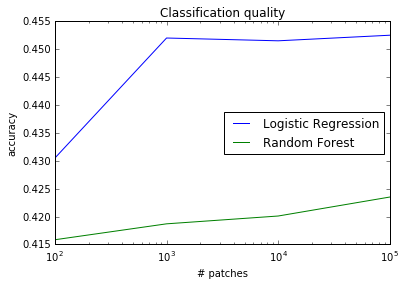

In [42]:
import matplotlib.pyplot as plt
plt.semilogx([100, 1000, 10000, 100000], lr_list, label = 'Logistic Regression')
plt.semilogx([100, 1000, 10000, 100000], rf_list, label = 'Random Forest')
plt.xlabel('# patches')
plt.ylabel('accuracy')
plt.title('Classification quality')
plt.legend(loc='right')
plt.show()

Для деревьев мы смогли улучшить классификацию, хоть и не значительно. Для логистической же регрессии существенной разницы после 1000 патчей не наблюдается, получается, что большую часть взаимодействий сеть улавливает и с 1000 патчей. И того как и в тестах выше логистическая регрессия показала более высокие результаты, при том что проиграла на цветовых признаках. Я считаю, что это связано с тем, что самостоятельно она не в состоянии выделять взаимосвязь между признаками в чем ей очень сильно помогает сеть.

## Выводы.

Автоэнокодеры действительно можно использовать в некоторых задачах для значительного повышения качества классификации. Особенно хорошо показывают они себя в паре с линейными методоми. В очередной раз повторюсь, что я считаю что тут дело в выявление взаимовсязей между признаками, которая фактически не присутствует в линейных моделях.

Ипользование очень большого числа патчей улучшает классификацию, но не значительно. 

Использования патчей с перекрытием сильно улучшает качество, хотя и приводит к сильному увеличению тестовой выборки. Опять же тут все понятно, мы получаем больше информации о выборке и взаимодействующих признаках.

Добавление скрытых слоев не дало в моем случие никакого прироста, но я уверен, что если долго и упорно крутить параметры моделей(как сети так и классификаторов), то наверняка можно получить прирост точности.